In [131]:
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
from scipy import stats

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exp_base_folder = '/home/maxdml/datacenter-OS/src/python/plot_utils/data/'

pd.set_option('float_format', '{:f}'.format)

In [137]:
def read_csv(csvfile, reset_time=True, second_ts=True, prune=True):
    df = pd.read_csv(csvfile, delimiter='\t').sort_values('TIME')
    if reset_time:
        df.TIME -= min(df.TIME)
    if second_ts:
        df.TIME /= 1e9
    if prune:
        value_df = df.loc[:, df.columns == 'VALUE']
        high = int(value_df.quantile(q=.9999))
        value_df = value_df.apply(lambda x: x[x < high])
        df = pd.concat([df.loc[:, 'TIME'], value_df], axis=1)
        df.dropna(inplace=True)
    return df

#TODO:
# - have this take the type of plot too
def plot_setup(setups, data_label, stacking=False):
    if stacking:
        nplots = 1
    else:
        nplots = len(setups)
        
    fig, axs = plt.subplots(1, nplots, squeeze=False, sharey=True, sharex=True)
    for i, setup in enumerate(setups.keys()):
        index = i % nplots
        sns.distplot(setups[setup][data_label].VALUE, ax=axs[0][index], label=setup, kde=False)
        axs[0][index].set(xlabel='latency (ns)', ylabel='#requests')
        if stacking:
            axs[0][index].set_title('{} latency'.format(data_label))
        else:
            axs[0][index].set_title('{} latency: {}'.format(data_label, setup))
            
        axs[0][index].legend()
        
    # fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True)
    # for i, setup in enumerate(setups.keys()):
    #     sns.scatterplot(x = setups[setup]['e2e'].TIME, y='VALUE', data=setups[setup]['e2e'], palette='colorblind', ax=axs[0][i])
    #     axs[0][i].set(xlabel='Timestamp', ylabel='latency (ns)')
    #     axs[0][i].set_title('End to end latency: {}'.format(setup))
    # fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
    # for i, setup in enumerate(setups.keys()):
    #     sns.boxplot(x=setups[setup]['e2e'].VALUE, ax=axs[0][i])
    #     axs[0][i].set(xlabel='latency (ns)')
    #     axs[0][i].set_title('End to end latency: {}'.format(setup))
    
#TODO:
#- have this take the data type as an argument
def prepare_data(exps, prune=False, tail=False):
    setups = {}
    for exp in exps:
        setups[exp] = {}
        exp_folder = os.path.join(exp_base_folder, exp, '')

        filename = os.path.join(exp_folder, 'rate_client', exp + '_end-to-end')
        setups[exp]['e2e'] = read_csv(filename)
        if prune:
            setups[exp]['e2e'] = setups[exp]['e2e'][setups[exp]['e2e'].VALUE < setups[exp]['e2e'].VALUE.quantile(.9999)]
        if tail:
            setups[exp]['e2e'] = setups[exp]['e2e'][setups[exp]['e2e'].VALUE > setups[exp]['e2e'].VALUE.quantile(.90)]
            
        filename = os.path.join(exp_folder, 'rate_client', exp + '_connect')
        setups[exp]['connect'] = read_csv(filename)
        if prune:
            setups[exp]['connect'] = setups[exp]['connect'][setups[exp]['connect'].VALUE < setups[exp]['connect'].VALUE.quantile(.9999)]
        if tail:
            setups[exp]['connect'] = setups[exp]['connect'][setups[exp]['connect'].VALUE > setups[exp]['connect'].VALUE.quantile(.90)]
            
        filename = os.path.join(exp_folder, 'rate_client', exp + '_send')
        setups[exp]['send'] = read_csv(filename)
        if prune:
            setups[exp]['send'] = setups[exp]['send'][setups[exp]['send'].VALUE < setups[exp]['send'].VALUE.quantile(.9999)]
        if tail:
            setups[exp]['send'] = setups[exp]['send'][setups[exp]['send'].VALUE > setups[exp]['send'].VALUE.quantile(.90)]
            
        filename = os.path.join(exp_folder, 'rate_client', exp + '_receive')
        setups[exp]['receive'] = read_csv(filename)
        if prune:
            setups[exp]['receive'] = setups[exp]['receive'][setups[exp]['receive'].VALUE < setups[exp]['receive'].VALUE.quantile(.9999)]
        if tail:
            setups[exp]['receive'] = setups[exp]['receive'][setups[exp]['receive'].VALUE > setups[exp]['receive'].VALUE.quantile(.90)]

        cachestats_filename = exp_folder + 'cachestat/cachestats.csv'
        df = pd.read_csv(cachestats_filename, delimiter='\t')
        df.dropna(inplace=True)
        df['WRITE_HIT%'] = df['WRITE_HIT%'].apply(lambda x: float(x.strip('%')))
        df['READ_HIT%'] = df['READ_HIT%'].apply(lambda x: float(x.strip('%')))
        df = df[(df.HITS > 0) | (df.MISSES > 0) | (df.DIRTIES > 0) | (df['READ_HIT%'] > 0) | (df['WRITE_HIT%'] > 0)]
        setups[exp]['cachestats'] =  df
        setups[exp]['cachestats'].TIME -= min(setups[exp]['cachestats'].TIME)
    
    return setups

def plot_all(exps):
    setups = prepare_data(exps)
    
    # Plots
    ###### latencies
    plot_setup(setups, 'e2e', stacking=True)
    plot_setup(setups, 'connect', stacking=True)
    plot_setup(setups, 'send', stacking=True)
    plot_setup(setups, 'receive', stacking=True)

    ###### Cachestat numbers
    cols = setups[exps[0]]['cachestats'].drop('TIME', axis=1).columns
    fig, axs = plt.subplots(len(cols), len(exps), squeeze=False, sharex=True)
    for i, setup in enumerate(setups.keys()):
        for j, col in enumerate(cols):
            sns.scatterplot(x = setups[setup]['cachestats'].TIME, y=col, data=setups[setup]['cachestats'], palette='colorblind', ax=axs[j][i])
            if i > 0:
                axs[j][i].set(xlabel='Timestamp (s)', ylabel='')
            else:
                axs[j][i].set(xlabel='Timestamp (s)', ylabel='{}'.format(col))
        axs[0][i].set_title('Cache statistics: {}'.format(setup))

In [127]:
exps = ['IVA-01', 'IVB-01', 'IVC-01', 'IIIA-01', 'IIIB-01', 'IIIC-01']
setups = prepare_data(exps)#['IVA-02'])
setups['IVA-01']['e2e'].describe()

,TIME,VALUE
count,748.000000,748.000000
mean,7.491732,207827.010695
std,4.324219,61226.829145
min,0.019996,121754.000000
25%,3.754995,164606.000000
50%,7.489995,192344.000000
75%,11.224994,242606.250000
max,14.979996,918892.000000


In [128]:
exps = ['IVA-01', 'IVB-01', 'IVC-01', 'IIIA-01', 'IIIB-01', 'IIIC-01']
setups = prepare_data(exps)
setups['IIIC-01']['e2e'].describe()

,TIME,VALUE
count,748.000000,748.000000
mean,7.486705,194687.704545
std,4.328455,42842.353972
min,0.000000,136444.000000
25%,3.747523,162179.000000
50%,7.482523,178121.500000
75%,11.217523,222156.500000
max,14.972525,356394.000000


<IPython.core.display.Javascript object>


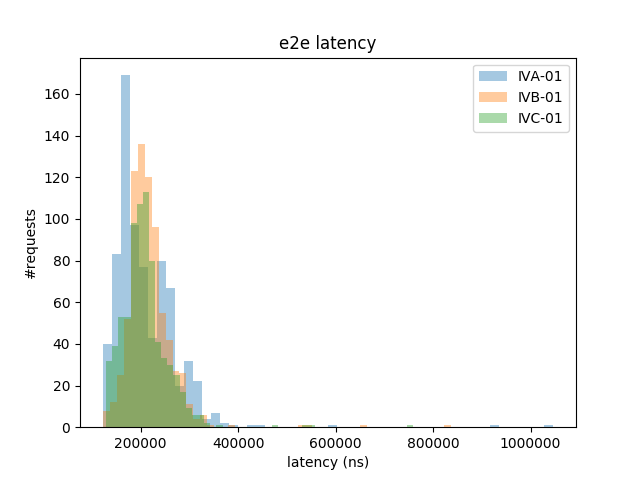

<IPython.core.display.Javascript object>


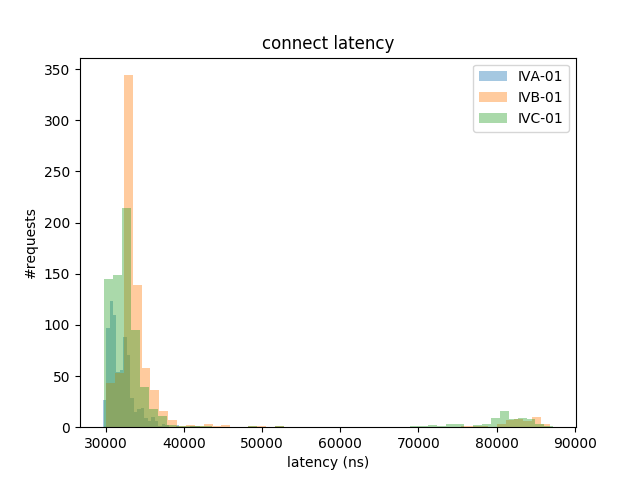

<IPython.core.display.Javascript object>


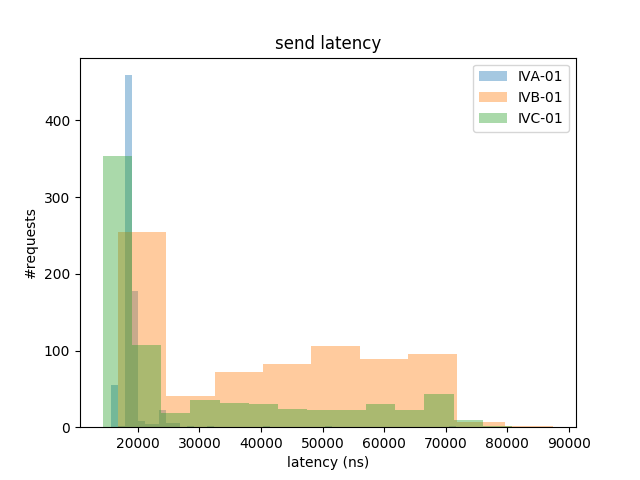

<IPython.core.display.Javascript object>


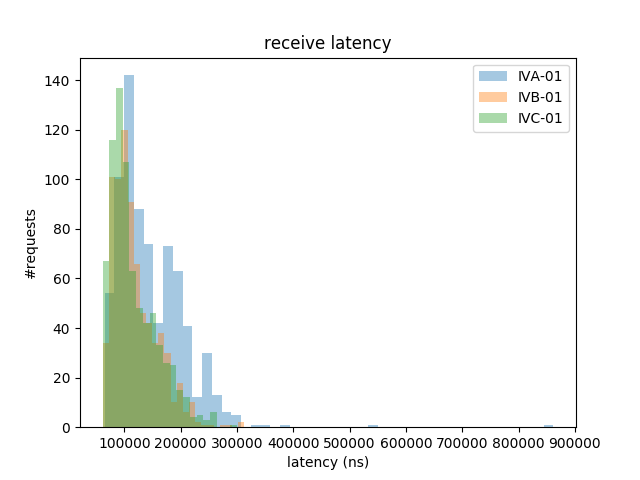

<IPython.core.display.Javascript object>


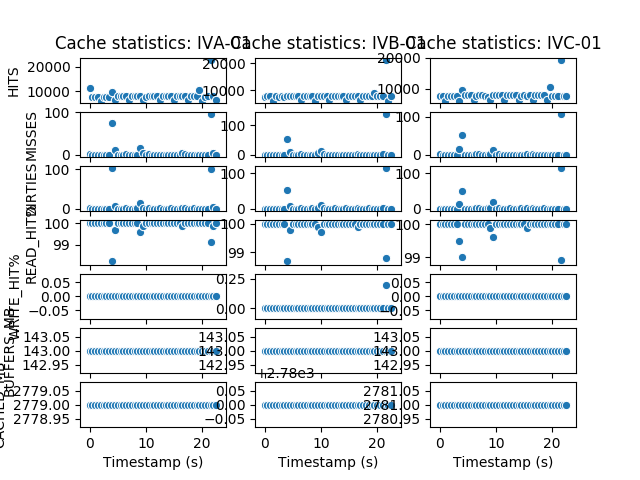

In [139]:
exps = ['IVA-01', 'IVB-01', 'IVC-01']
plot_all(exps)

<IPython.core.display.Javascript object>


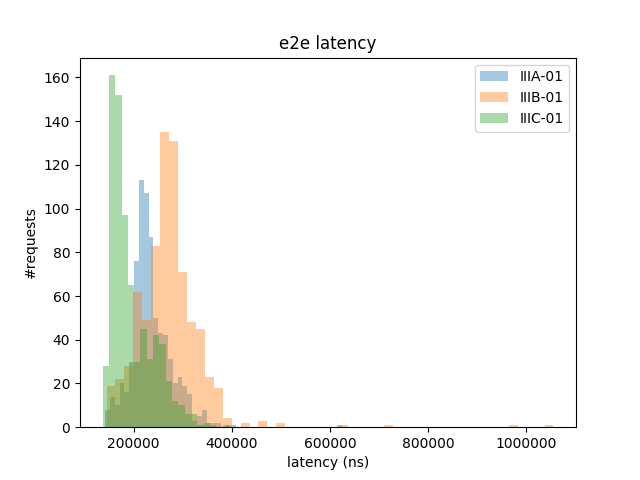

<IPython.core.display.Javascript object>


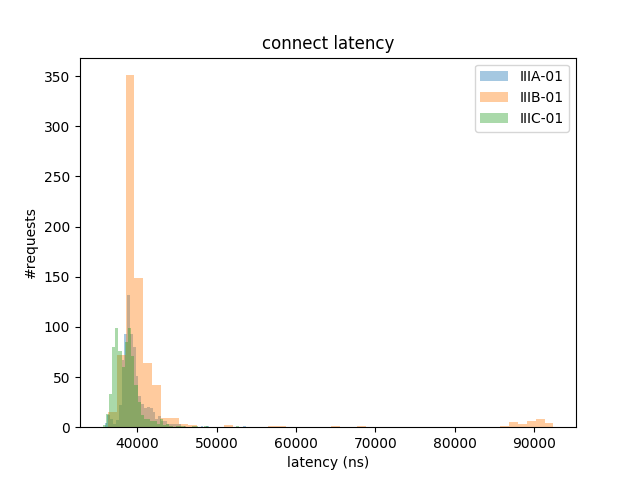

<IPython.core.display.Javascript object>


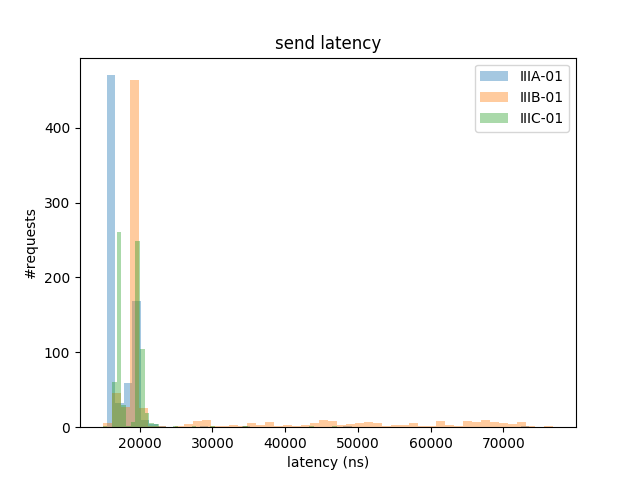

<IPython.core.display.Javascript object>


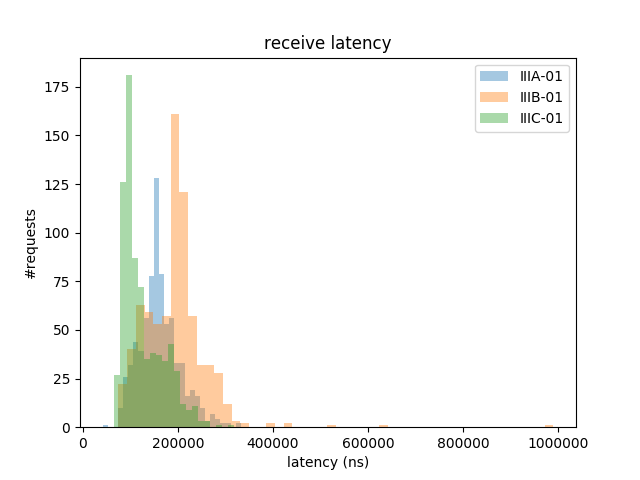

<IPython.core.display.Javascript object>


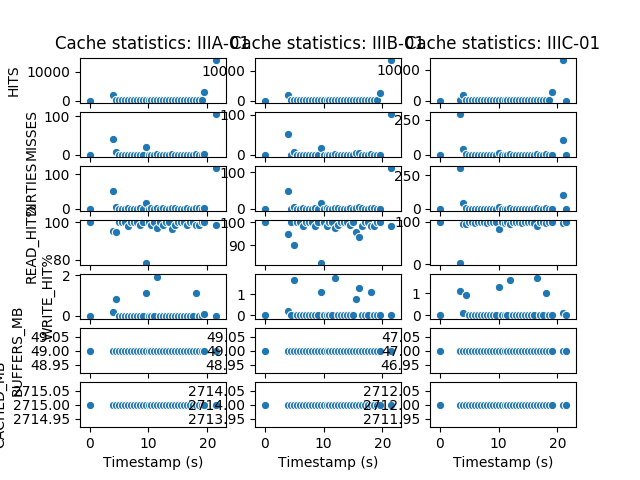

In [138]:
exps = ['IIIA-01', 'IIIB-01', 'IIIC-01']
plot_all(exps)

<IPython.core.display.Javascript object>


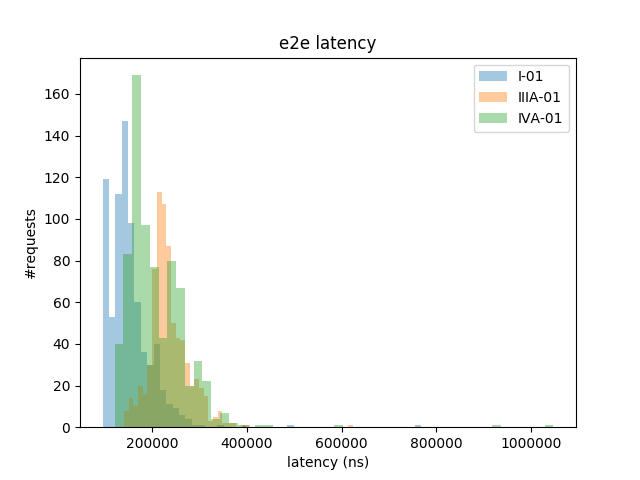

<IPython.core.display.Javascript object>


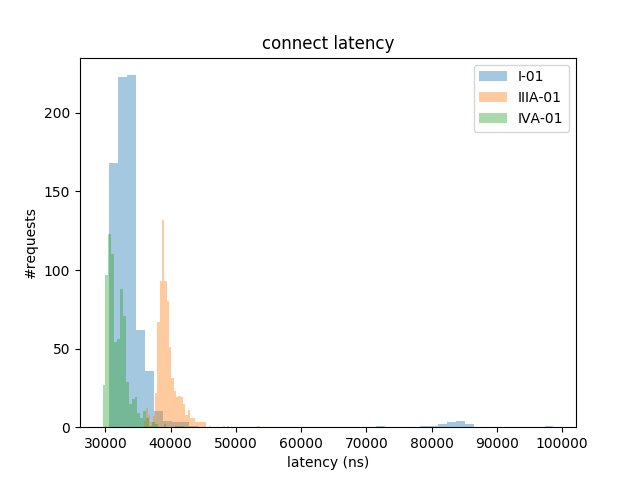

<IPython.core.display.Javascript object>


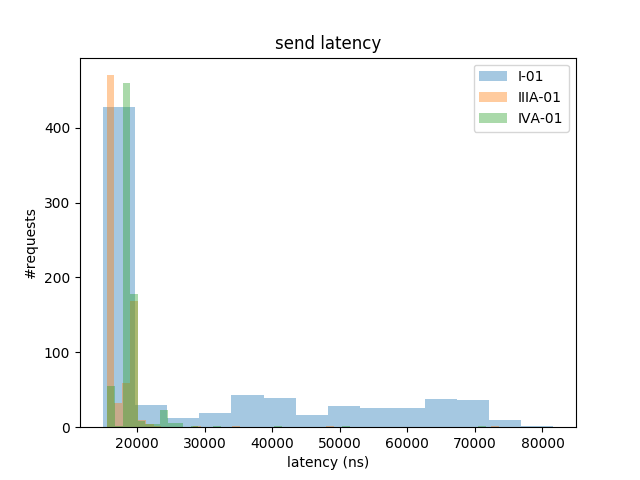

<IPython.core.display.Javascript object>


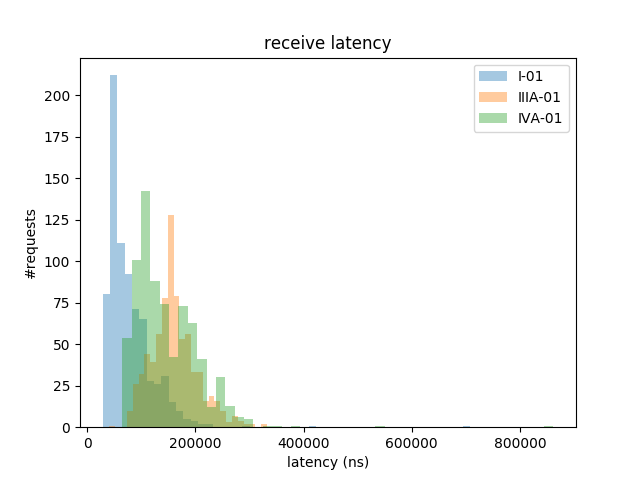

<IPython.core.display.Javascript object>


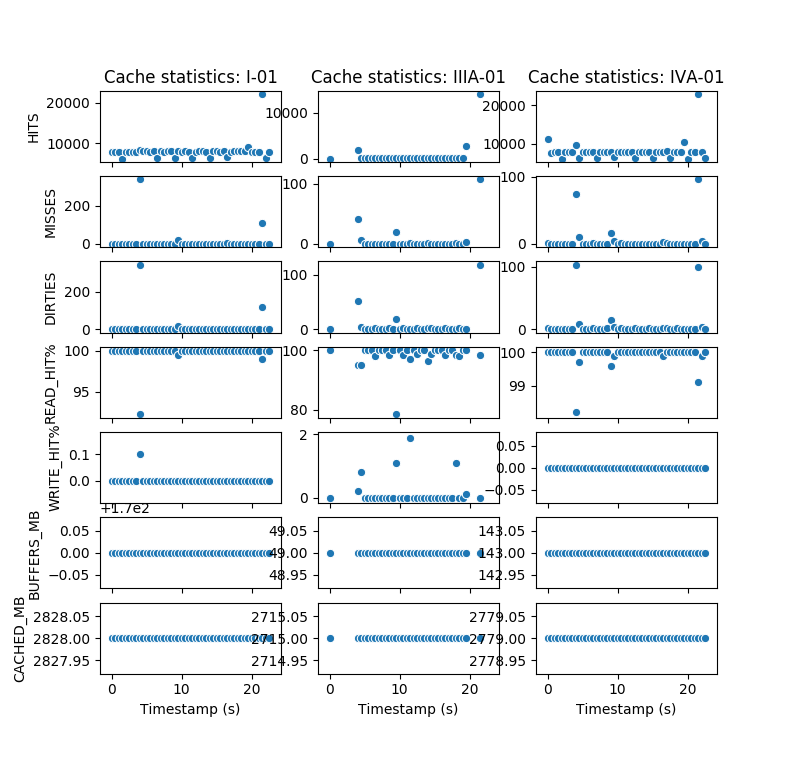

In [140]:
exps = ['I-01', 'IIIA-01', 'IVA-01']
plot_all(exps)

<IPython.core.display.Javascript object>


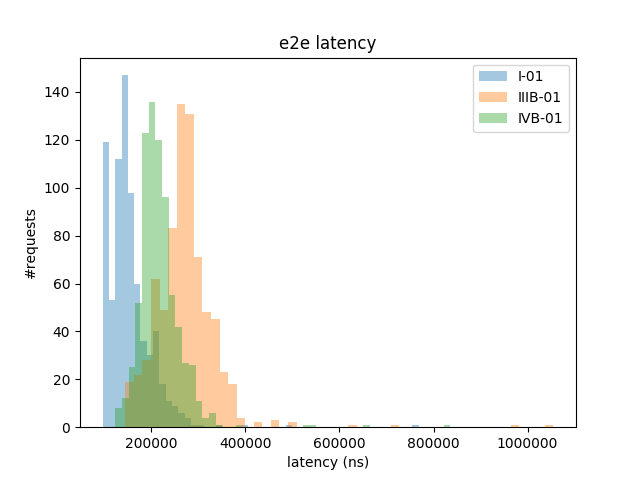

<IPython.core.display.Javascript object>


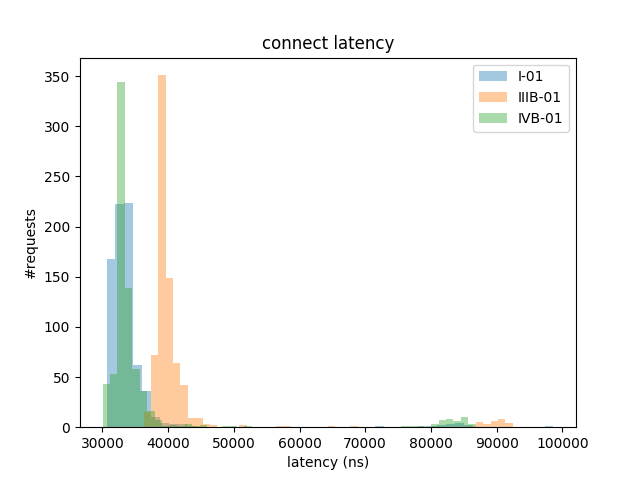

<IPython.core.display.Javascript object>


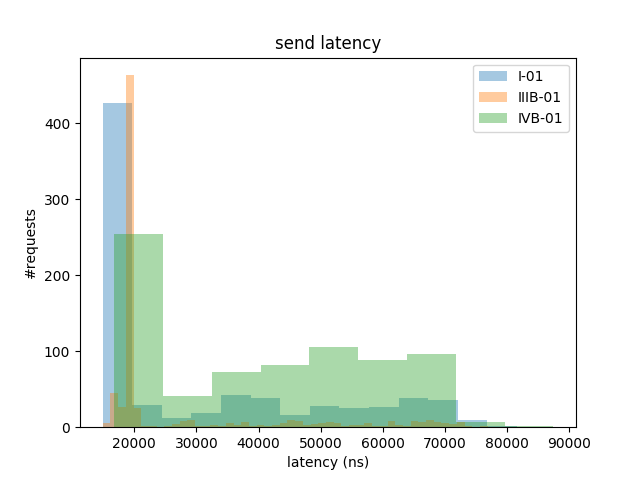

<IPython.core.display.Javascript object>


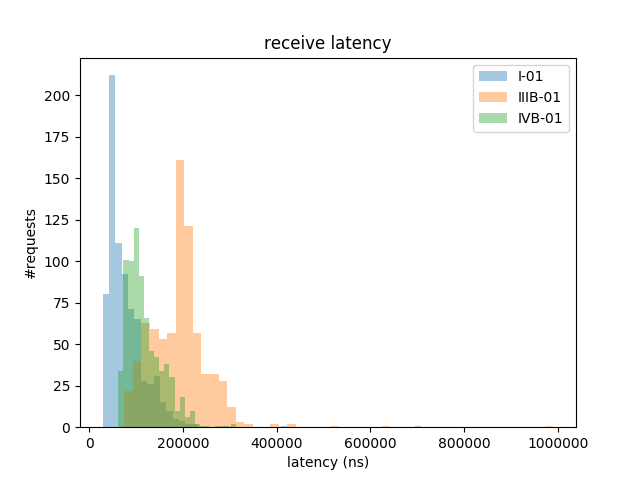

<IPython.core.display.Javascript object>


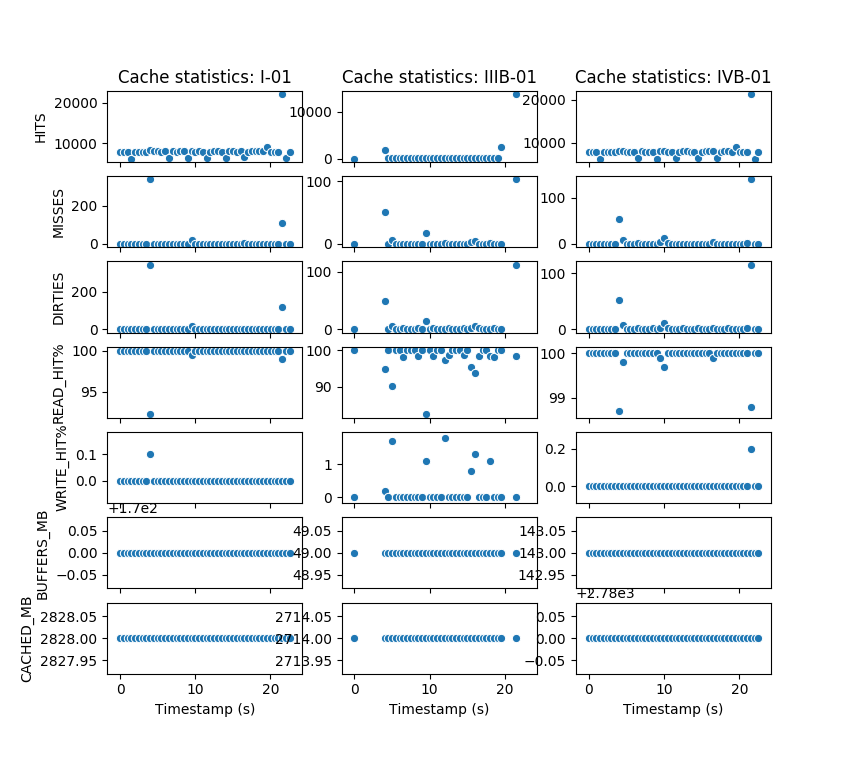

In [141]:
exps = ['I-01', 'IIIB-01', 'IVB-01']
plot_all(exps)

/home/maxdml/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


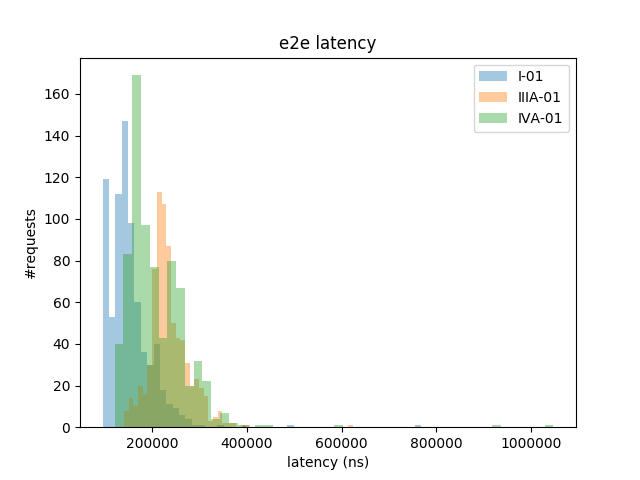

<IPython.core.display.Javascript object>


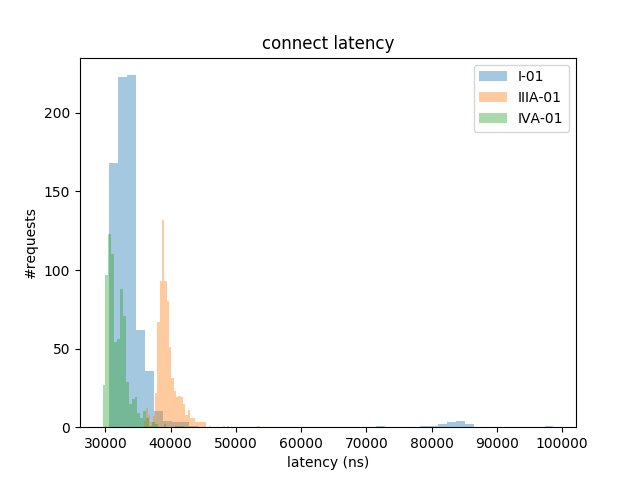

<IPython.core.display.Javascript object>


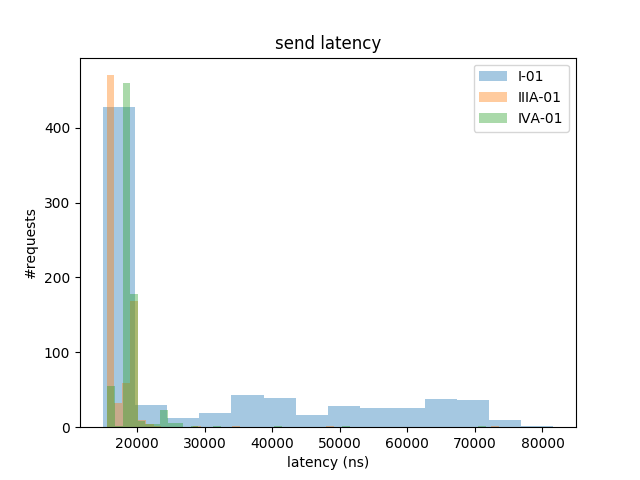

<IPython.core.display.Javascript object>


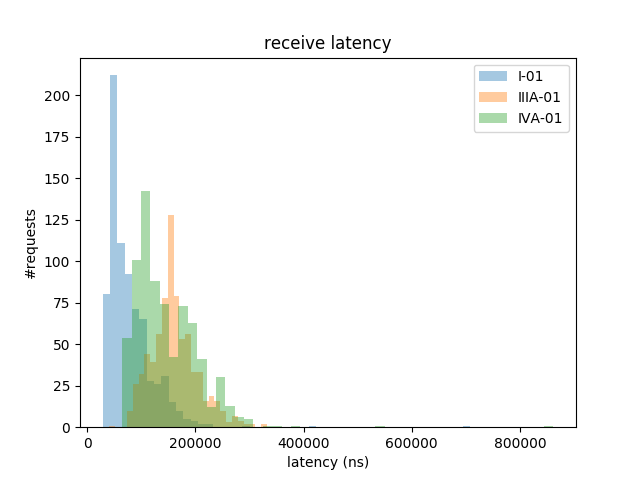

/home/maxdml/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


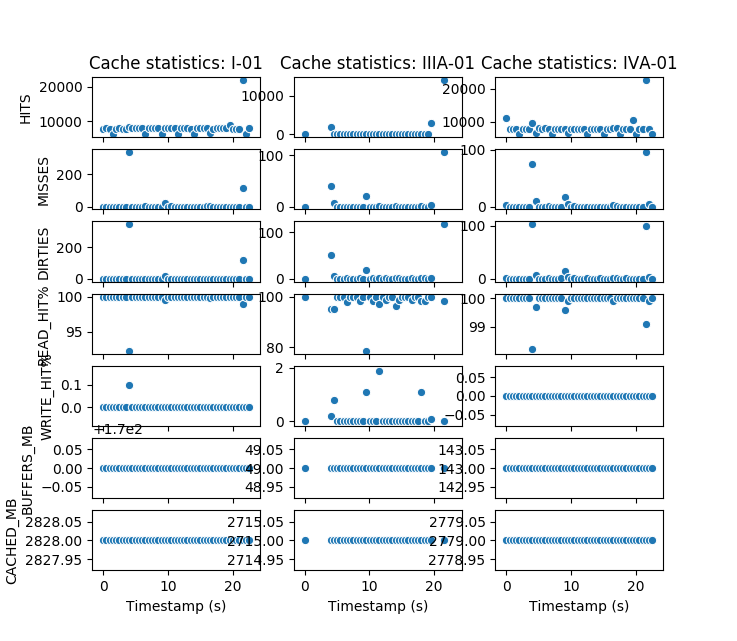

In [143]:
exps = ['I-01', 'IIIA-01', 'IVA-01']
plot_all(exps)

/home/maxdml/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


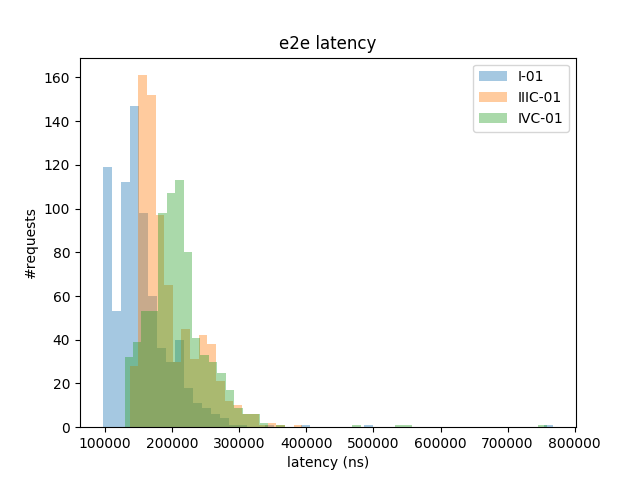

<IPython.core.display.Javascript object>


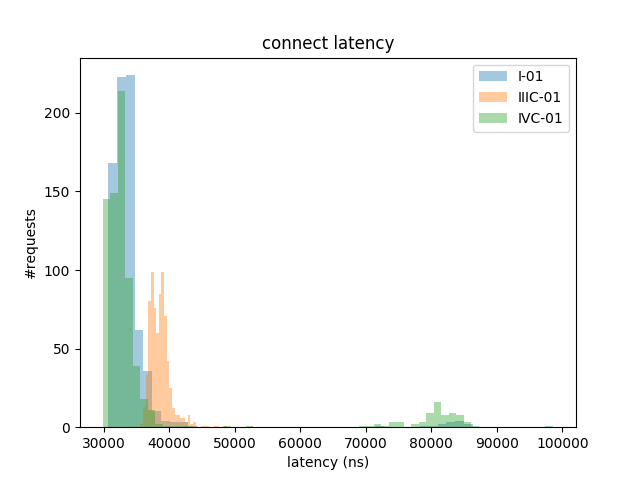

<IPython.core.display.Javascript object>


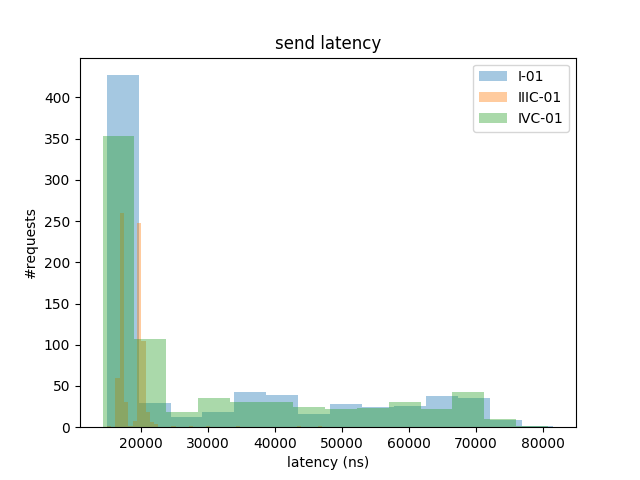

<IPython.core.display.Javascript object>


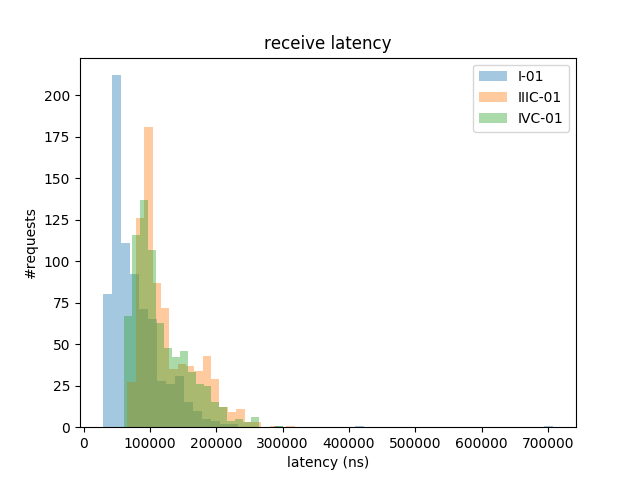

/home/maxdml/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


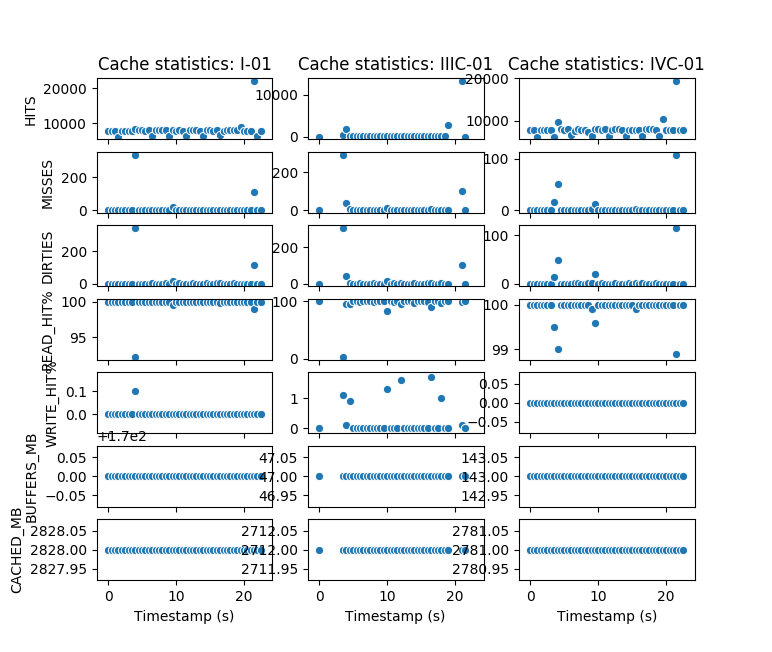

In [142]:
exps = ['I-01', 'IIIC-01', 'IVC-01']
plot_all(exps)